# Plot frequency of occurrence of tweets about the best animals 

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import nltk
import seaborn as sns

### Read in the CSV made separately
twitter_scrape_retweets.ipynb creates this; I saved a version as "tweet_replies_lock" so that I wouldn't lose the results

In [2]:
tweet_num = 1273621086933057536
input_filename = 'tweet_replies_'+str(tweet_num)+'.csv'
input_filepath = os.path.join('Data', input_filename)

df_retwe = pd.read_csv(input_filepath)
df_retwe.head()

,id,created_at,favorites,retweets,text
0,1273756192804941824,2020-06-18 23:15:16,0,0,b'@rachelgwenllian Dolphin'
1,1273756140162232320,2020-06-18 23:15:03,0,0,b'@rachelgwenllian There is not a turtle!!! Bu...
2,1273756094502891520,2020-06-18 23:14:52,0,0,b'@rachelgwenllian Shark! \xf0\x9f\x98\x8e\xf0...
3,1273756061128892416,2020-06-18 23:14:44,0,0,b'@rachelgwenllian Dolphin. I still keep a lis...
4,1273756001175515137,2020-06-18 23:14:30,0,0,b'@rachelgwenllian Dolphin'


### Concatenate all of the tweeted words and search for keywords
I couldn't quite decide how to do this so first I created a list with all of the words from all of the tweets, thinking I might search that list. But in the following block, I used the original pandas DataFrame to run the analysis. 


In [3]:
all_the_words_nest = []

for index, row in df_retwe.iterrows():
    row_words = row.text.split(" ")
    all_the_words_nest.append(row_words)
    
all_the_words = [item for sublist in all_the_words_nest for item in sublist]

In [4]:
keywords = ['plankton', 'cuttlefish', 'ray', 'shark', 'dragon', 'orca', 'horse', 
            'jelly', 'dolphin', 'whale', 'puffin', 'penguin', 'sunfish', 'narwhal', 'manatee',
            'squid', 'mola', 'octopus', 'otter', 'turtle', 'nudibranch', 'mantis',
            'starfish', 'hermit', 'clown', 'lion', 'killer', 'sting', 'tang', 'surgeon',
            'dory', 'nemo'
           ]

a = df_retwe['text'].str.lower().str.cat(sep=' ')
# nltk.download('punkt')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)

N = 1000
common_words = pd.DataFrame(word_dist.most_common(N),
                    columns=['Word', 'Frequency'])

output_filename = 'common_words_'+str(tweet_num)+'.csv'
output_filepath = os.path.join('Data', input_filename)

common_words.to_csv(output_filepath)

### Use the keywords to create a new DataFrame with the counts of each keyword
This was a little more brute force than I would've liked&mdash;not as elegant as it could be. But examination of the CSV allows you to pick the keywords that rank at the top (and are actually critters) and analyze them further. 

In [5]:
counts = np.zeros(len(keywords))
data = {'keywords':keywords, 'mentions':counts}
keyword_counts = pd.DataFrame(data)

for word in keywords:
    df_retwe[word] = df_retwe.astype(str).sum(axis=1).str.contains(word)

df_keywords = df_retwe[keywords]

key_sums = df_keywords.sum()
key_sums

plankton        1
cuttlefish      1
ray            61
shark          38
dragon          2
orca           23
horse         303
jelly          19
dolphin        57
whale          95
puffin          0
penguin         2
sunfish         0
narwhal         3
manatee         6
squid           3
mola            0
octopus        50
otter           9
turtle         12
nudibranch      0
mantis          0
starfish        5
hermit          4
clown           8
lion           32
killer         11
sting           6
tang            2
surgeon         0
dory            0
nemo            4
dtype: int64

### Combine terms that likely mean the same thing
- e.g., "killer" and "orca" both refer to the same thing
- can't currently distinguish response of plain "whale" from something like "killer whale"

In [6]:
key_sums['orca'] = key_sums['orca']+key_sums['killer']
key_sums['seahorse'] = key_sums['horse']
key_sums['jellyfish'] = key_sums['jelly']
key_sums['hermit crab'] = key_sums['hermit']
key_sums['clownfish'] = key_sums['clown']+key_sums['nemo']
key_sums['royal blue tang'] = key_sums['tang']+key_sums['dory']+key_sums['surgeon']
del key_sums['killer'], key_sums['horse'], key_sums['jelly'], key_sums['tang']
del key_sums['dory'], key_sums['surgeon'], key_sums['hermit']
del key_sums['clown'], key_sums['nemo']
    
key_sums

plankton             1
cuttlefish           1
ray                 61
shark               38
dragon               2
orca                34
dolphin             57
whale               95
puffin               0
penguin              2
sunfish              0
narwhal              3
manatee              6
squid                3
mola                 0
octopus             50
otter                9
turtle              12
nudibranch           0
mantis               0
starfish             5
lion                32
sting                6
seahorse           303
jellyfish           19
hermit crab          4
clownfish           12
royal blue tang      2
dtype: int64

In [7]:
df_key_sums = pd.DataFrame(key_sums)
df_key_sums.reset_index(inplace = True)
df_key_sums.columns = ['keywords', 'mentions']
df_key_sums.sort_values(by = 'mentions', ascending = False, inplace = True)
df_key_sums

,keywords,mentions
23,seahorse,303
7,whale,95
2,ray,61
6,dolphin,57
15,octopus,50
3,shark,38
5,orca,34
21,lion,32
24,jellyfish,19
26,clownfish,12


### Plot the results!

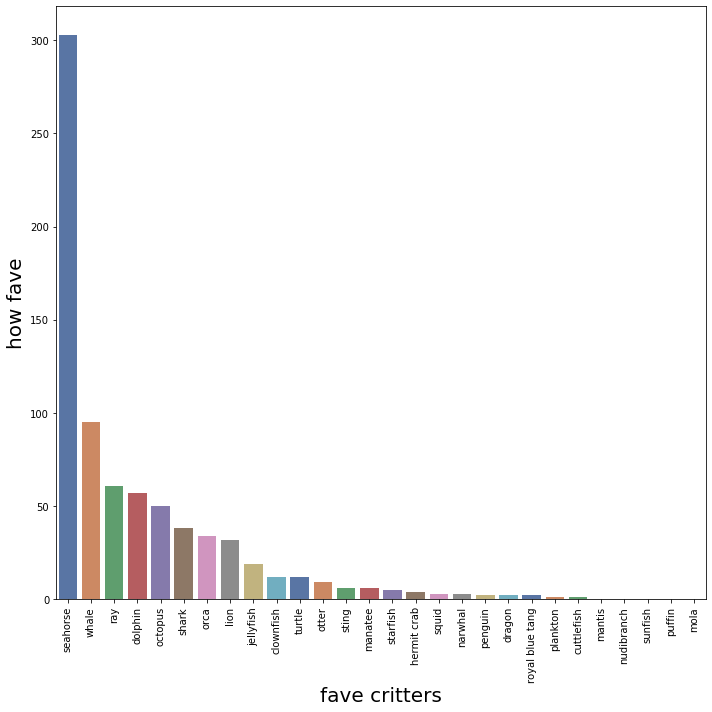

In [8]:
bar_width = 0.35

fig, axs = plt.subplots(figsize = (10, 10))
barplot = sns.barplot(x=df_key_sums['keywords'], y=df_key_sums['mentions'], palette="deep")
plt.xticks(rotation=90)
axs.set_xlabel('fave critters', fontsize=20)
axs.set_ylabel('how fave', fontsize=20)
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=20
plt.tight_layout()
# plt.bar(df_key_sums['keywords'], df_key_sums['sums'])

In [9]:
fig = barplot.get_figure()

output_filename = 'tweet_replies_'+str(tweet_num)+'.png'
output_filepath = os.path.join('Figs', output_filename)

fig.savefig(output_filepath) 